In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import edward as ed
import numpy as np
import tensorflow as tf
from edward.models import Beta,Bernoulli,RelaxedBernoulli, MultivariateNormalDiag, Dirichlet, OneHotCategorical,Normal,MultivariateNormalFullCovariance,Mixture,ParamMixture
from edward.models.random_variables import TransformedDistribution
from scipy.stats import norm,lognorm
import math
import time
from build_dataset import build_dataset_1dim_gmm

In [2]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

In [3]:
def hist_point(N,x_data):
    hist = [[] for i in range(80)]
    point = np.array([[0.0]*N]*2,dtype=np.float32)
    width = 0.25
    height = 1.0/(width*N)
    for n in range(N):
        d=x_data[n]
        h=int((d-5.0)/width)
        hist[h].append(n)
        point[0][n]=5.0+h*width
        point[1][n]=(len(hist[h])-1)*height
    return point,width,height

In [4]:
def gmm_bbvi_1dim_gmm_z_mu(N,x_data,n_iter,lambda_m0_init=10.0,lambda_m1_init=20.0):
    start = time.time()
    ds = tf.contrib.distributions
    #generative model 
    pi = 0.5
    mu0 = Normal(loc=tf.constant(10.0),scale=tf.constant(0.5))
    mu1 = Normal(loc=tf.constant(20.0),scale=tf.constant(0.5))
    z = [Bernoulli(probs = pi, dtype = tf.float32) for n in range(N)]
    x = [Normal(loc=mu0*(1.0-z[n])+mu1*z[n],scale=0.5) for n in range(N)]
    print("generative model")
    #variational model
    lambda_m0= tf.Variable(lambda_m0_init)
    lambda_m1= tf.Variable(lambda_m1_init)
    lambda_s0= tf.nn.softplus(tf.Variable(1.5))
    lambda_s1= tf.nn.softplus(tf.Variable(1.5))
    qmu0 = Normal(loc=lambda_m0, scale=lambda_s0) 
    qmu1= Normal(loc=lambda_m1, scale=lambda_s1) 
    temperature = [tf.Variable(5.0) for n in range(N)]
    lambda_z = [tf.nn.sigmoid(tf.Variable(0.0)) for n in range(N)]
    qz = [RelaxedBernoulli(temperature[n], probs = lambda_z[n]) for n in range(N)]
    print("variational model")
    latent_vars = {z[n]:qz[n] for n in range(N)}
    latent_vars[mu0]=qmu0
    latent_vars[mu1]=qmu1

    data = {x[n]:x_data[n] for n in range(N)}

    inference = ed.KLqp(latent_vars=latent_vars,data=data)
    inference.initialize(n_iter=n_iter,n_samples=1)
    print("inference")
    print(time.time()-start)
    sess=ed.get_session()
    tf.global_variables_initializer().run()
    loss = []
    variational_parameter = []
    variational_parameter.append(sess.run([lambda_m0, lambda_s0, lambda_m1, lambda_s1, temperature, lambda_z]))
    for _ in range(inference.n_iter):
            info_dict = inference.update()
            loss.append(info_dict['loss'])
            variational_parameter.append(sess.run([lambda_m0, lambda_s0, lambda_m1, lambda_s1, temperature, lambda_z]))
    print(time.time()-start)          
    return loss,variational_parameter

<IPython.core.display.Javascript object>


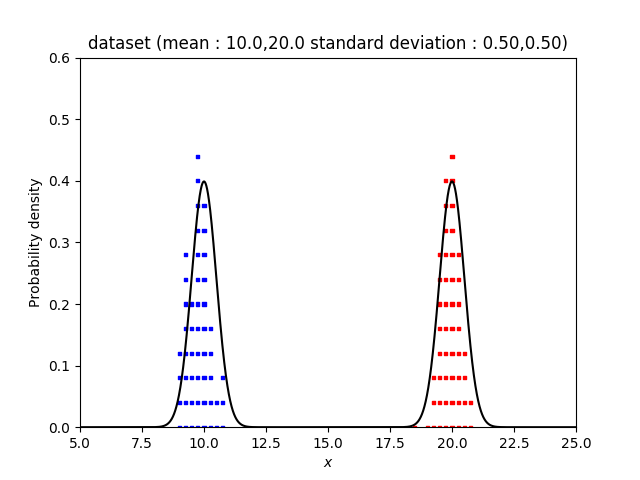

In [5]:
%matplotlib nbagg
N=100
mean_true = np.array([10.0,20.0])
std_true = np.array([0.5,0.5])
pi_true = np.array([0.5,0.5])

x_data,label =build_dataset_1dim_gmm(N,mean_true,std_true,pi_true)
point,width,height = hist_point(N,x_data)

area = [[5.0]*N]
grid = np.linspace(start=5.0,stop=25.0,num=10000)
plt.title("dataset (mean : {0:.1f},".format(mean_true[0]) +"{0:.1f} ".format(mean_true[1])+"standard deviation : {0:.2f},".format(std_true[0])+"{0:.2f})".format(std_true[1]))
plt.xlabel("$x$")
plt.ylabel("Probability density")
plt.xlim(5.0,25.0)
plt.ylim(0.0,0.6)
plt.plot(grid,norm.pdf(x=grid,loc=mean_true[0], scale=std_true[0])*pi_true[0]+norm.pdf(x=grid,loc=mean_true[1], scale=std_true[1])*pi_true[1],color="black")
color =[]
for t,p in enumerate(label):
    color.append([p,0.0,1.0-p])
plt.scatter(point[0],point[1],s=area,c=color,marker='s')
plt.show()
#plt.savefig("dataset_ex3.png")


In [6]:
loss, variational_parameter = gmm_bbvi_1dim_gmm_z_mu(N,x_data,n_iter=5000,lambda_m0_init=8.0,lambda_m1_init=22.0 )

generative model
variational model
inference
63.92607641220093
405.47146248817444


<IPython.core.display.Javascript object>


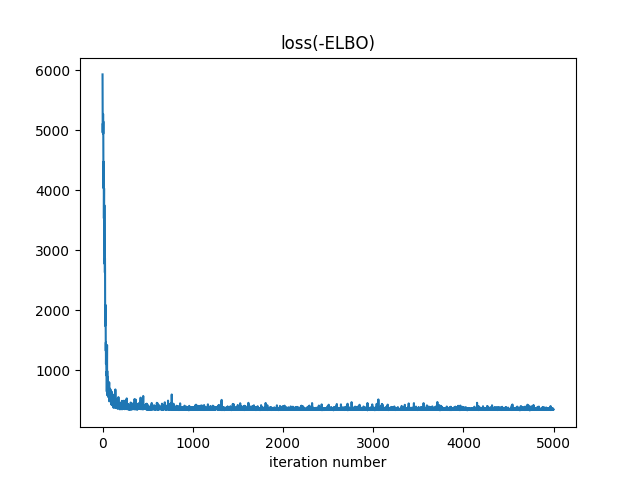

In [7]:
%matplotlib nbagg
plt.title("loss(-ELBO)")
plt.plot(loss)
plt.xlabel("iteration number")
plt.show()
#plt.savefig("loss_ex3.png")

<IPython.core.display.Javascript object>


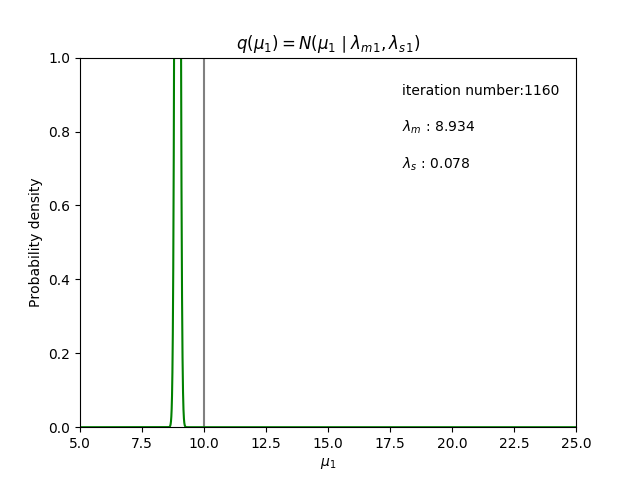

In [8]:
%matplotlib nbagg
grid = np.linspace(start=5.0,stop=25.0,num=10000)
fig = plt.figure()
plt.title("$q(\mu_1)=N(\mu_1\mid{\lambda_m}_1,{\lambda_s}_1)$")
plt.xlabel("$\mu_1$")
plt.ylabel("Probability density")
plt.xlim(5.0,25.0)
plt.ylim(0.0,1.0)
plt.axvline(x=mean_true[0],color="gray")
artists = []
for t,vp in enumerate(variational_parameter):
    if t%10 == 0:
        im = plt.plot(grid,norm.pdf(x=grid,loc=vp[0], scale=vp[1]),color="green")
        text = [plt.text(18,0.9,"iteration number:"+str(t)),
                     plt.text(18,0.8,"$\lambda_m$ : {0:.3f}".format(vp[0])),
                     plt.text(18,0.7,"$\lambda_s$ : {0:.3f}".format(vp[1]))]
        artists.append(im+text)
ani = animation.ArtistAnimation(fig,artists)
plt.show()
#ani.save("mu1_ex3.gif", writer='imagemagick', fps=4)

<IPython.core.display.Javascript object>


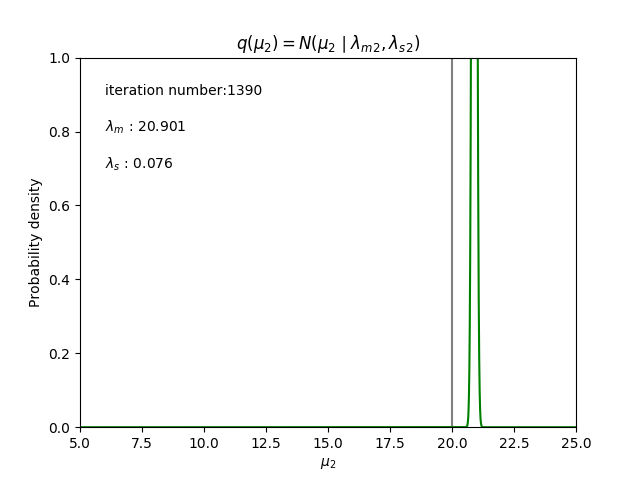

In [9]:
%matplotlib nbagg
grid = np.linspace(start=5.0,stop=25.0,num=10000)
fig = plt.figure()
plt.title("$q(\mu_2)=N(\mu_2\mid{\lambda_m}_2,{\lambda_s}_2)$")
plt.xlabel("$\mu_2$")
plt.ylabel("Probability density")
plt.xlim(5.0,25.0)
plt.ylim(0.0,1.0)
plt.axvline(x=mean_true[1],color="gray")
artists = []
for t,vp in enumerate(variational_parameter):
    if t%10 == 0:
        im = plt.plot(grid,norm.pdf(x=grid,loc=vp[2], scale=vp[3]),color="green")
        text = [plt.text(6,0.9,"iteration number:"+str(t)),
                     plt.text(6,0.8,"$\lambda_m$ : {0:.3f}".format(vp[2])),
                     plt.text(6,0.7,"$\lambda_s$ : {0:.3f}".format(vp[3]))]
        artists.append(im+text)
ani = animation.ArtistAnimation(fig,artists)
plt.show()
#ani.save("mu2_ex3.gif", writer='imagemagick', fps=4)

<IPython.core.display.Javascript object>


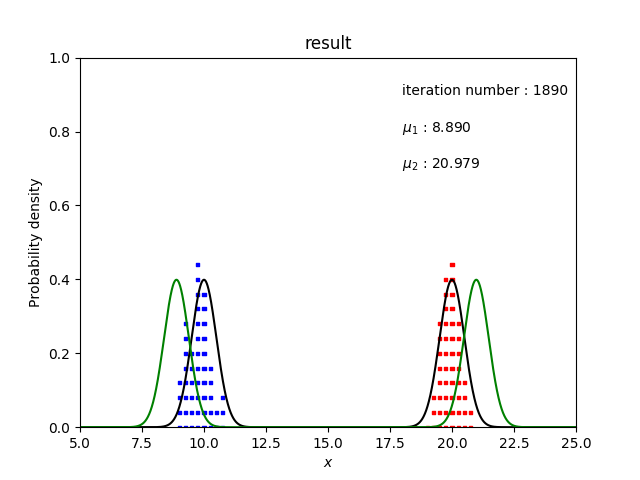

In [10]:
%matplotlib nbagg
grid = np.linspace(start=5.0,stop=25.0,num=10000)
fig = plt.figure()
plt.title("result")
plt.xlabel("$x$")
plt.ylabel("Probability density")
plt.xlim(5.0,25.0)
plt.ylim(0.0,1.0)
plt.plot(grid,norm.pdf(x=grid,loc=mean_true[0], scale=std_true[0])*pi_true[0]+norm.pdf(x=grid,loc=mean_true[1], scale=std_true[1])*pi_true[1],color="black")
area = [[5.0]*N]

artists = []
for t,vp in enumerate(variational_parameter):
    if t%5 == 0:
        im=plt.plot(grid,norm.pdf(x=grid,loc=vp[0], scale=std_true[0])*pi_true[0]+norm.pdf(x=grid,loc=vp[2], scale=std_true[1])*pi_true[1],
                 color="green")
        color =[]
        for zn,p in enumerate(vp[5]):
            color.append([p,0.0,1.0-p])
        im_z=plt.scatter(point[0],point[1],s=area,c=color,marker='s')
        text = [plt.text(18,0.9,"iteration number : "+str(t)),
                     plt.text(18,0.8,"$\mu_1$ : {0:.3f}".format(vp[0])),
                     plt.text(18,0.7,"$\mu_2$ : {0:.3f}".format(vp[2]))]
        artists.append(im+[im_z]+text)
ani = animation.ArtistAnimation(fig,artists)
plt.show()
#ani.save("GMM_2_result.gif", writer='imagemagick', fps=4)

In [11]:
for t,vp in enumerate(variational_parameter):
    if t % 10 == 0:
        print(t,vp[4][10],vp[5][10])

0 5.0 0.5
10 4.28363 0.275717
20 4.13783 0.128225
30 3.57921 0.0662107
40 2.94266 0.0356526
50 2.29964 0.0201615
60 2.26916 0.0156017
70 2.53191 0.0144445
80 2.49055 0.0115754
90 2.52869 0.0104257
100 2.51354 0.00836192
110 2.39262 0.00651374
120 2.16753 0.00461981
130 2.14255 0.00372903
140 2.12273 0.00338988
150 2.19259 0.00331132
160 2.17894 0.00279958
170 2.1497 0.00249577
180 1.99751 0.00223882
190 1.7559 0.00194324
200 1.82094 0.00188799
210 1.90859 0.00185124
220 2.06374 0.00188303
230 1.96723 0.00175747
240 1.85319 0.00158573
250 1.97414 0.00157383
260 2.23726 0.00165007
270 2.30917 0.00151388
280 2.24142 0.00138556
290 2.15727 0.00129767
300 2.19178 0.001288
310 2.29401 0.00132168
320 2.38959 0.00135217
330 2.46362 0.00137546
340 2.50884 0.00140009
350 2.60979 0.0014495
360 2.5617 0.00132503
370 2.49944 0.00122657
380 2.36667 0.00106142
390 2.37055 0.00102019
400 2.48185 0.00104431
410 2.38594 0.000932464
420 2.2898 0.000838916
430 2.3229 0.000822035
440 2.38598 0.000828294
45